Preprocessing Anime dataset from Kaggle

In [21]:
from collections import defaultdict
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import re
import string

1. Data preprocessing

1.1 Data Cleaning

In [2]:
# remove unwanted features (columns) from the dataset
anime_df = pd.read_csv("animes.csv")
anime_df.rename(columns={'title': 'name'}, inplace=True)
anime_df.drop(['aired', 'ranked', 'img_url', 'link'], axis=1, inplace=True)

#removing unwanted characters from the anime name strings
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)

    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)
anime_df.head(5)

,uid,name,synopsis,genre,episodes,members,popularity,score
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [3]:
anime_df.rename(columns={'uid': 'anime_uid'}, inplace=True)
anime_df.episodes.replace({'Unknown':np.nan},inplace=True)

anime_df.head(5)

,anime_uid,name,synopsis,genre,episodes,members,popularity,score
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [4]:
# replace the characters "[]'" with an empty space as the genre column is already of type string
anime_df['genre'] = anime_df['genre'].str.replace("'", "", regex=False)
anime_df['genre'] = anime_df['genre'].str.replace("[", "", regex=False)
anime_df['genre'] = anime_df['genre'].str.replace("]", "", regex=False)

anime_df.head(5)

,anime_uid,name,synopsis,genre,episodes,members,popularity,score
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire",1.0,214621,502,8.83


In [ ]:
user_ratings_df = pd.read_csv("reviews.csv")
user_ratings_df.head(5)

1.2 Merging the datasets

In [ ]:
# remove unwanted columns
user_ratings_df.drop(['uid', 'link'], axis=1, inplace=True)
user_ratings_df.head(5)

In [ ]:
# change profile names into unique IDs (i.e. integers)
user_ratings_df.profile = pd.factorize(user_ratings_df.profile)[0]
user_ratings_df.rename(columns={'profile': 'user_id'}, inplace=True)
user_ratings_df.head(10)

In [ ]:
merged_anime_reviews_df = pd.merge(anime_df, user_ratings_df, on='anime_uid')
merged_anime_reviews_df.rename(columns={'score_x':'avg_rating', 'text': 'review_text'},inplace=True)

merged_anime_reviews_df.drop('review_text', axis=1, inplace=True)

merged_anime_reviews_df.head()

Categorical encoding -> Separating genres into their own respective column

In [ ]:
# replace the characters "[]'" with an empty space as the genre column is already of type string
# merged_anime_reviews_df['genre'] = merged_anime_reviews_df['genre'].str.replace("'", "", regex=False)
# merged_anime_reviews_df['genre'] = merged_anime_reviews_df['genre'].str.replace("[", "", regex=False)
# merged_anime_reviews_df['genre'] = merged_anime_reviews_df['genre'].str.replace("]", "", regex=False)

# merged_anime_reviews_df.head(5)

Clean data -> drop duplicates + NaN values

In [ ]:
# merged_anime_reviews_df.drop_duplicates(inplace=True)
# merged_anime_reviews_df.dropna(inplace=True)

In [5]:
anime_df.drop_duplicates(inplace=True)
anime_df.dropna(inplace=True)

Create genre df using one-hot encoding -> represents if an anime contains a genre or not by using 1s (yes) and 0s (no)

In [6]:
genre_encoding_df = anime_df['genre'].str.get_dummies(sep=', ')

genre_encoding_df.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


Merge the genre encoding with the main dataframe

In [7]:
anime_df = pd.concat([anime_df, genre_encoding_df], axis=1)
anime_df.drop(['genre'], axis=1, inplace=True)

anime_df.head()

,anime_uid,name,synopsis,episodes,members,popularity,score,Action,Adventure,Cars,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,22.0,995473,28,8.83,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,13.0,581663,98,8.83,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...",64.0,1615084,4,9.23,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,1.0,214621,502,8.83,1,0,0,...,0,0,0,0,0,1,0,1,0,0


Feature Selection for clustering

In [8]:
# selected_features = ['episodes', 'members', 'popularity', 'score'] + genre_encoding_df.columns.tolist()
selected_features = ['episodes', 'members', 'popularity', 'score']

print(selected_features)

['episodes', 'members', 'popularity', 'score']


Scaling -> Scale the selected features so that they have similar ranges. Here, we will use MinMaxScaler to scale the values between 0 and 1.

In [22]:
# scaler = MinMaxScaler()
# scaled_anime = scaler.fit_transform(anime_df[selected_features])
ss = StandardScaler()
scaled_anime = ss.fit_transform(anime_df[selected_features])

scaled_anime_pd = pd.DataFrame(scaled_anime)
scaled_anime_pd = pd.concat([scaled_anime_pd, genre_encoding_df], axis=1)
scaled_anime_pd.head()
# print(scaled_anime)

,0,1,2,3,Action,Adventure,Cars,Comedy,Dementia,Demons,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0.284402,4.753104,-1.654484,2.520080,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.220634,9.972751,-1.678425,2.530346,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.029327,5.700587,-1.663595,2.530346,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.113397,16.369599,-1.683510,2.940996,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.225748,1.911255,-1.578001,2.530346,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Clustering

Determine the number of clusters K to use using the elbow method and silhouette scores

In [23]:
# compute the number of clusters to use
sse = [] #sum of squared errors

# silhouette scores range from -1 to 1: 
# 1 = points are perfectly assigned in a clsuter and clusters are easily distinguishable
# 0 = clusters are overlapping
# -1 = points are wrongly assigned in a cluster

silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10) #max_iter = 100
    kmeans.fit(scaled_anime)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(scaled_anime, kmeans.labels_)
    silhouette_coefficients.append(ss)

In [24]:
print("SSE: ", sse)
print("Silhouette scores: ", silhouette_coefficients)

SSE:  [40664.758813421955, 31228.01455224356, 22373.59291511839, 18777.063777805313, 16319.345633687626, 14246.128202941418, 12257.304314280147, 11130.639141752306, 10152.276540800045]
Silhouette scores:  [0.4225774676896914, 0.4401638910526729, 0.44221969962503765, 0.33705450051850977, 0.32984536648522794, 0.3178365152932983, 0.3204548100761156, 0.30254463758073885, 0.3030686298200848]


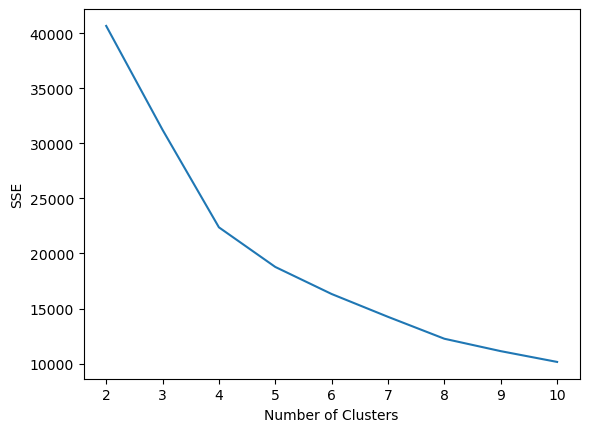

In [25]:
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

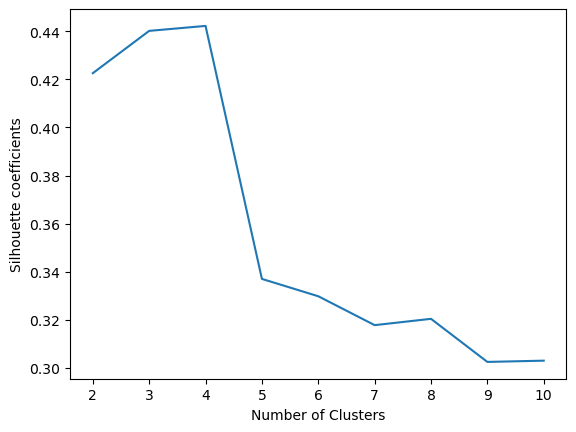

In [26]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

We will use K = 4 after observing the results from the above 2 graphs (elbow method and silhouette scores)

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
anime_clusters_before_pca = kmeans.fit_predict(scaled_anime)

Observing recommendations before PCA

In [28]:
# return a list of similar anime that belong to the same cluster as the input anime
def get_similar_anime(anime_name):
    anime_index = anime_df[anime_df['name'] == anime_name].index[0]
    anime_cluster = anime_clusters_before_pca[anime_index]
    similar_anime_indexes = [i for i, cluster in enumerate(anime_clusters_before_pca) if cluster == anime_cluster and i != anime_index]
    similar_anime = anime_df.iloc[similar_anime_indexes]['name'].tolist()
    
    return similar_anime[:11]

In [49]:
get_similar_anime('Heartcatch Precure')

['Koukaku Kidoutai 20',
 'Nodame Cantabile Finale  Mine to Kiyora no Saikai',
 'Saraiya Goyou',
 'Saint Seiya Meiou Hades Meikaihen',
 'Lupin III Part II',
 'Kuroko no Basket 2nd Season NGshuu',
 'InuYasha Movie 3 Tenka Hadou no Ken',
 'Haikyuu Movie 2 Shousha to Haisha',
 'Ginga Eiyuu Densetsu Die Neue These  Seiran 1',
 'Detective Conan OVA 10 Kid in Trap Island',
 'Bungou Stray Dogs Dead Apple']

Dimensionality Reduction

Using PCA to reduce the number of features to help improve the clustering results

In [31]:
anime_df.shape

(15070, 50)

In [35]:
selected_features_pca = ['episodes', 'members', 'popularity', 'score'] + genre_encoding_df.columns.tolist()
pca_anime_df = anime_df.copy()
pca_anime_df = pca_anime_df[selected_features_pca]

pca_anime_df.head()

,episodes,members,popularity,score,Action,Adventure,Cars,Comedy,Dementia,Demons,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,25.0,489888,141,8.82,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,22.0,995473,28,8.83,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13.0,581663,98,8.83,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,64.0,1615084,4,9.23,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,214621,502,8.83,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [36]:
pca = PCA().fit(pca_anime_df)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

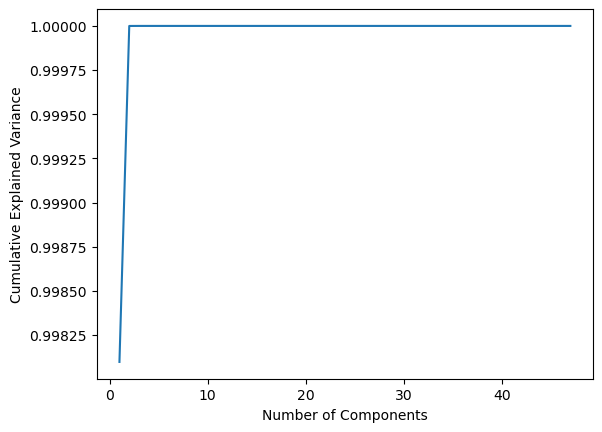

In [37]:
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [38]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(pca_anime_df)

Calculate optimal K for clustering after PCA

In [39]:
# compute the number of clusters to use
sse = [] #sum of squared errors

# silhouette scores range from -1 to 1: 
# 1 = points are perfectly assigned in a clsuter and clusters are easily distinguishable
# 0 = clusters are overlapping
# -1 = points are wrongly assigned in a cluster

silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10) #max_iter = 100
    kmeans.fit(pca_result)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(pca_result, kmeans.labels_)
    silhouette_coefficients.append(ss)

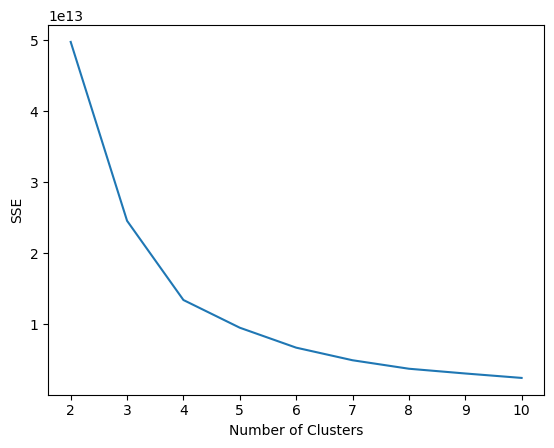

In [40]:
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

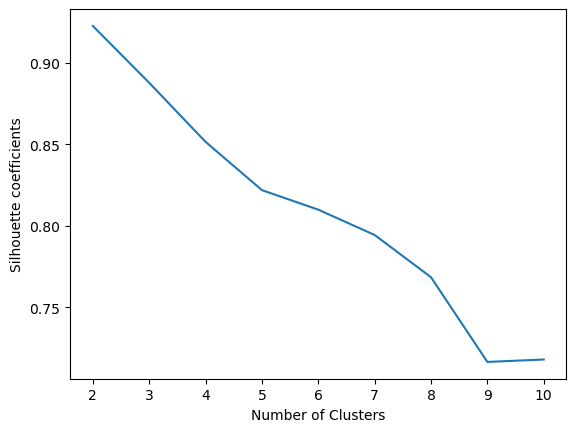

In [41]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

From the above 2 graphs, the elbow point and silhouette scores indicate that the optimal value for K = 4.

In [42]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(pca_result)
anime_clusters_after_pca = kmeans.predict(pca_result)

Recommend Similar Anime

In [43]:
# return a list of similar anime that belong to the same cluster as the input anime
def get_similar_anime(anime_name):
    anime_index = anime_df[anime_df['name'] == anime_name].index[0]
    anime_cluster = anime_clusters_after_pca[anime_index]
    similar_anime_indexes = [i for i, cluster in enumerate(anime_clusters_after_pca) if cluster == anime_cluster and i != anime_index]
    similar_anime = anime_df.iloc[similar_anime_indexes]['name'].tolist()
    
    return similar_anime[:11]

In [44]:
get_similar_anime('Death Note')

['Kizumonogatari III Reiketsuhen',
 'Owarimonogatari 2nd Season',
 'Gintama',
 'Gintama Movie 2 Kanketsuhen  Yorozuya yo Eien Nare',
 'Gintama Enchousen',
 'Kaguyahime no Monogatari',
 'Noragami OVA',
 'Kobayashisan Chi no Maid Dragon Valentine Soshite Onsen  Amari Kitai Shinaide Kudasai',
 'KOn Live House',
 'Gekkan Shoujo Nozakikun Specials',
 'Doukyonin wa Hiza Tokidoki Atama no Ue']

In [18]:
def cluster_plot(data, nclusters):
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    X = data.copy()

    km = KMeans(n_clusters=nclusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)


    # Visualize it:
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_.astype(float))

    # plot the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', label='centroids')
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

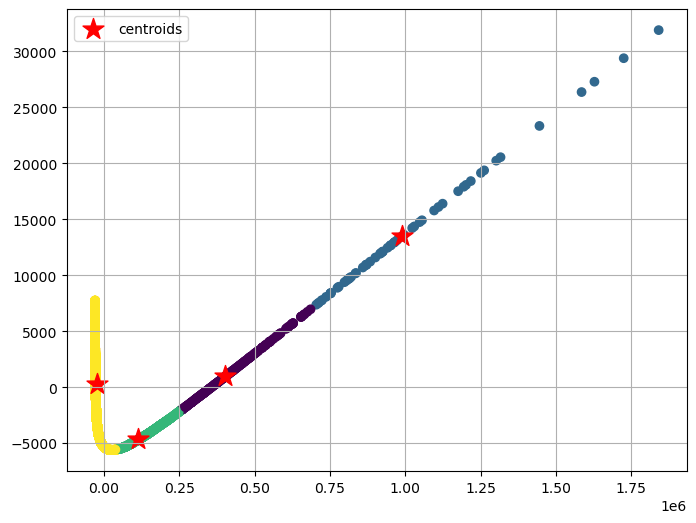

In [45]:
pca_pd = pd.DataFrame(pca_result)
cluster_plot(pca_pd, 4)

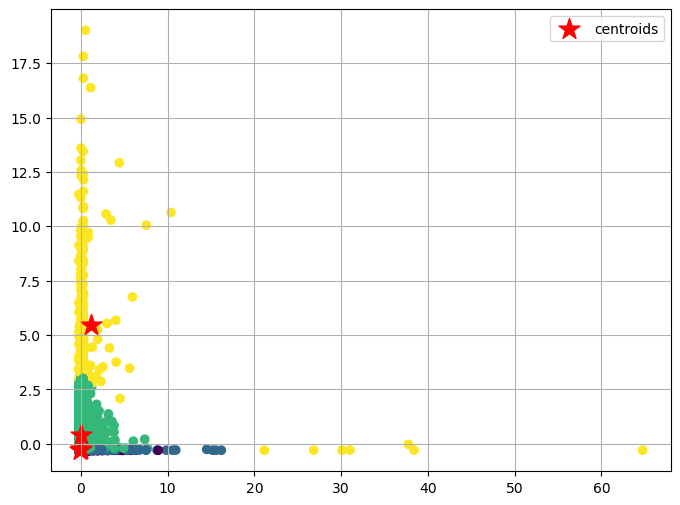

In [30]:
before_pca = pd.DataFrame(scaled_anime)
# before_pca.head()
cluster_plot(before_pca, 4)

In [ ]:
# separate genres into separate columns, with a maximum of 5 different genres to limit the dimensions of the dataframe
genres = merged_anime_reviews_df['genre'].str.split(",", expand=True)
genres = genres.iloc[:,:5]
genres.columns = ['genre1', 'genre2', 'genre3','genre4', 'genre5']

genres.head(10)

In [ ]:
merged_anime_reviews_df.drop(columns='genre', axis=1, inplace=True)
merged_anime_reviews_df = pd.concat([merged_anime_reviews_df, genres], axis=1)

merged_anime_reviews_df.head()

Separating the Scores column

In [ ]:
# merged_anime_reviews_df['scores'] = [merged_anime_reviews_df['scores'][0].translate({ord(i): "" for i in "{}'"}) for anime in merged_anime_reviews_df['scores']]

merged_anime_reviews_df['scores'] = merged_anime_reviews_df['scores'].str.replace("'", "", regex=False)
merged_anime_reviews_df['scores'] = merged_anime_reviews_df['scores'].str.replace("{", "", regex=False)
merged_anime_reviews_df['scores'] = merged_anime_reviews_df['scores'].str.replace("}", "", regex=False)

merged_anime_reviews_df.head(5)

In [ ]:
merged_anime_reviews_df['scores'] = [re.sub("[^0-9,]", "", anime) for anime in merged_anime_reviews_df['scores']]
merged_anime_reviews_df.head()

In [ ]:
# Order of columns -> Overall: 7, Story: 7, Animation: 9, Sound: 8, Character: 8, Enjoyment: 8
ratings = merged_anime_reviews_df['scores'].str.split(",", expand=True)
ratings.columns = ['Overall', 'Story', 'Animation','Sound', 'Character', 'Enjoyment']

ratings.head(10)

In [ ]:
merged_anime_reviews_df.drop(['score_y', 'scores'], axis=1, inplace=True)
merged_anime_reviews_df = pd.concat([merged_anime_reviews_df, ratings], axis=1)

merged_anime_reviews_df.head()

1.3 Deal with missing values

In [ ]:
# see how many null values are present within our merged dataframe (merged_anime_reviews_df)
missing_value = pd.DataFrame({
    'Missing Value': merged_anime_reviews_df.isnull().sum()
})
display(missing_value)

In [ ]:
# see how many null values are present within our initial dataset (anime_df)
anime_df.isnull().sum()

In [ ]:
# remove all null values from both dataframes
merged_anime_reviews_df.dropna(inplace=True)
anime_df.dropna(inplace=True)

merged_anime_reviews_df.isnull().sum()

In [ ]:
anime_df.isnull().sum()

1.4 Duplicate Data

In [ ]:
# remove duplicated rows where the same user has rated the same anime again
duplicate = merged_anime_reviews_df.duplicated(subset=['anime_uid','user_id']).sum()
print('There are {} duplicated rows in merged_anime_reviews_df'.format(duplicate))

duplicate = anime_df.duplicated().sum()
print('There are {} duplicated rows in anime_df'.format(duplicate))

In [ ]:
merged_anime_reviews_df.drop_duplicates(subset=['anime_uid','user_id'],inplace=True)
anime_df.drop_duplicates(inplace=True)

#checking to see if duplicates have been removed
duplicate = merged_anime_reviews_df.duplicated(subset=['anime_uid','user_id']).sum()
print('There are {} duplicated rows in merged_anime_reviews_df'.format(duplicate))

duplicate = anime_df.duplicated().sum()
print('There are {} duplicated rows in anime_df'.format(duplicate))

1.5 Indexing

In [ ]:
merged_anime_reviews_df.shape

In [ ]:
# we see that the indexes for the last 4 entries range from 317475-317478, but there are only 129263 
# entries so the indexes need to be reset
merged_anime_reviews_df.reset_index(drop=True,inplace=True)

# dropping last row due to several NaN values
merged_anime_reviews_df.drop(merged_anime_reviews_df.tail(1).index, inplace=True)

merged_anime_reviews_df.tail()

In [ ]:
merged_anime_reviews_df.dtypes

In [ ]:
# convert rating scores from object to int
merged_anime_reviews_df[['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']] = merged_anime_reviews_df[
    ['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']].apply(pd.to_numeric)

merged_anime_reviews_df.dtypes

In [ ]:
categorical_df = merged_anime_reviews_df.select_dtypes('object')
numerical_df = merged_anime_reviews_df.select_dtypes('number')

categorical_df.head()

Categorical data

In [ ]:
genre_dummy_df = pd.get_dummies(categorical_df[['genre1', 'genre2', 'genre3', 'genre4', 'genre5']])
genre_dummy_df.reset_index(drop=True,inplace=True)

genre_dummy_df.head()

Numerical data 

In [ ]:
numerical_df.head()

In [ ]:
ratings_df = pd.DataFrame().assign(Overall=merged_anime_reviews_df['Overall'], Story=merged_anime_reviews_df['Story']
, Animation=merged_anime_reviews_df['Animation'], Sound=merged_anime_reviews_df['Sound'], Character=merged_anime_reviews_df['Character']
, Enjoyment=merged_anime_reviews_df['Enjoyment'])

ratings_df.head()

In [ ]:
numerical_df.drop(['user_id', 'Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment'], axis=1, inplace=True)
numerical_df.set_index('anime_uid', inplace=True)

numerical_df.head()

1.8 Feature Scaling

The dataset consists of features that have a very large range, in particular the numerical features. Examples of this will be shown below.

In order for the machine learning models to interpret these features on the same scale, feature scaling will be necessary.

In [ ]:
numerical_df.head()

create a different ratings table -> do not include in feature scaling

when creating clustering dataframe, have catergorical and numerical df as in the kaggle thing, then append the ratings dataframe afterwards
so the ratings are preserved.

1.8.1 Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df),columns=numerical_df.columns)

scaled_numerical_df.head()

In [ ]:
complete_clusering_df = pd.concat([scaled_numerical_df, genre_dummy_df, ratings_df], axis = 1)

complete_clusering_df.head()

In [ ]:
complete_clusering_df.shape

2.0 Content-based filtering -> Clustering on anime features

In [ ]:
# compute the number of clusters to use
sse = [] #sum of squared errors

# silhouette scores range from -1 to 1: 
# 1 = points are perfectly assigned in a clsuter and clusters are easily distinguishable
# 0 = clusters are overlapping
# -1 = points are wrongly assigned in a cluster

silhouette_coefficients = []

# takes just over 20mins to execute
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10) #max_iter = 100
    kmeans.fit(complete_clusering_df)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(complete_clusering_df, kmeans.labels_)
    silhouette_coefficients.append(ss)

In [ ]:
print("SSE: ", sse)
print("Silhouette scores: ", silhouette_coefficients)

2.1 The Elbow Method

In [ ]:
# plot sse scores
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

2.2 Silhouette Score

In [ ]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

Using both the graphs generated using the Elbow method and the Silhouette scores to determine K, 
we see that the elbow point seems to be at when k = 4, and the silhouette_score rapidly decreases after k = 4.

Therefore, the number of the clusters that will be used is k = 4.

In [ ]:
clusters = KMeans(n_clusters=4, n_init = 10)
clusters.fit(complete_clusering_df)

merged_anime_reviews_df['Cluster'] = clusters.labels_
merged_anime_reviews_df.head()

# complete_clusering_df['Cluster'] = clusters.labels_
# complete_clusering_df.head()

In [ ]:
merged_anime_reviews_df.Cluster.value_counts()
# complete_clusering_df.Cluster.value_counts()

In [ ]:
# cluster0 = complete_clusering_df[complete_clusering_df['Cluster'] == 0].drop('Cluster',axis=1).mean()
# cluster0.sort_values(ascending=False)[0:15]